<a href="https://colab.research.google.com/github/danieljryu/coffeesnob/blob/main/w207_final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Forest Cover Type - Baseline

The goal of this project is to build a model that uses cartographic features about a cell of forest land to accurately predict the predominant kind of tree cover for the cell.

### Data Source
The outcome variable (forest cover type) comes from the US Forest Service, while the feature variables come from a combination of the US Geological survey as well as the USFS. This data encapsulates four wilderness areas in the Roosevelt National Forest; because these areas are preserved from most human disturbance, we assume forest cover types are a result of natural processes represented by the independent variables (although this assumption is not necessary to generate an effective model).

### Feature Definitions
The raw data contains a mixture of continuous and binary variables, as defined below: 
- Elevation - Elevation in meters
-Aspect - Aspect in degrees azimuth
-Slope - Slope in degrees
-Horizontal_Distance_To_Hydrology - Horz Dist to nearest surface water features
-Vertical_Distance_To_Hydrology - Vert Dist to nearest surface water features
-Horizontal_Distance_To_Roadways - Horz Dist to nearest roadway
-Hillshade_9am (0 to 255 index) - Hillshade index at 9am, summer solstice
-Hillshade_Noon (0 to 255 index) - Hillshade index at noon, summer solstice
-Hillshade_3pm (0 to 255 index) - Hillshade index at 3pm, summer solstice
-Horizontal_Distance_To_Fire_Points - Horz Dist to nearest wildfire ignition points
-Wilderness_Area (4 binary columns, 0 = absence or 1 = presence) - Wilderness area designation
-Soil_Type (40 binary columns, 0 = absence or 1 = presence) - Soil Type designation
-Cover_Type (7 types, integers 1 to 7) - Forest Cover Type designation

Additional transformed variables to potentially train our models:
- "Wilderness_Area" - combining the 4 binary columns into one categorical variable (1-4), making an assumption about exclusivity of areas that needs to be checked.
- "Soil_Type" - combining the 40 binary columns into one categorical variable (1-40), making an assumption about exclusivity of soil types that needs to be checked.
- "Total_Distance_To_Hydrology" - Euclidean distance using "Horizontal" and "Vertical" distances
- Binned versions of continuous variables

### Testing Plan
We plan to tune and compare a variety of models, optimizing toward the highest possible $F_1$ score (a metric which balances precision and recall). All models will be trained on labeled data, and tested against "development" data using a 50-50 split. 

Potential models to test include:
- k Nearest Neighbors
- Naive Bayes
- Logistic Regression
- Decision Trees
- Support Vector Machines

# Data Load

In [ ]:
# Install Kaggle from PIP
# ! pip install kaggle

# Download the data via API
# ! kaggle competitions download -c forest-cover-type-prediction

In [ ]:
# Import Packages
# import kaggle
import numpy as np
import pandas as pd
import re 

# Learning libs
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier, export_graphviz

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Producing Decision Tree diagrams
from IPython.display import Image, display
import pydotplus
from subprocess import call

# For other 
import copy
from textwrap import wrap

np.random.seed(0)

In [ ]:
# Import Train and Test data from Kaggle
# train_kaggle = pd.read_csv('../../data/raw/forest-cover-type-prediction/train.csv')
# test_kaggle = pd.read_csv('../../data/raw/forest-cover-type-prediction/test.csv')

In [ ]:
# For colab only - upload train.csv and test.csv files:
from google.colab import files
uploaded = files.upload()

Saving test.csv to test.csv
Saving train.csv to train.csv


In [ ]:
# For colab only - load csv stored in memory to dataframes
import io
test_kaggle = pd.read_csv(io.BytesIO(uploaded['test.csv'])).set_index('Id')
train_kaggle = pd.read_csv(io.BytesIO(uploaded['train.csv']))

In [ ]:
# Shuffle the data
# shuffle = np.random.permutation(np.arange(train_kaggle.shape[0]))
train_kaggle = train_kaggle.sample(frac = 1)

# Separate in to train/dev sets
train_pct = .5 # .8 for 80/20 split
split = int(train_kaggle.shape[0] * train_pct)

train_data = train_kaggle.iloc[:split,:].set_index('Id')
train_labels = train_kaggle.iloc[:split,].loc[:, ['Id', 'Cover_Type']].set_index('Id')
dev_data = train_kaggle.iloc[split:,:].loc[:,].set_index('Id')
dev_labels = train_kaggle.iloc[split:,].loc[:, ['Id', 'Cover_Type']].set_index('Id')

In [ ]:
print(train_data.shape)
print(dev_data.shape)
print(train_labels.shape)
print(dev_labels.shape)

(7560, 55)
(7560, 55)
(7560, 1)
(7560, 1)


In [ ]:
# Write data to dataframes
# train_data.to_csv('../../data/processed/train_data.csv')
# train_labels.to_csv('../../data/processed/train_labels.csv')
# dev_data.to_csv('../../data/processed/dev_data.csv')
# dev_labels.to_csv('../../data/processed/dev_labels.csv')


# Exploratory Data Analysis

In [ ]:
# Column List
train_data.columns

Index(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
       'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10',
       'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14',
       'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18',
       'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22',
       'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26',
       'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30',
       'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34',
       'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38',
       'Soil_Type39', 'Soil_Type40

In [ ]:
# Statistics Summary
train_data.describe()

Elevation       Aspect  ...  Soil_Type40   Cover_Type
count  7560.000000  7560.000000  ...  7560.000000  7560.000000
mean   2753.337037   157.380820  ...     0.033069     4.002116
std     420.598044   110.649951  ...     0.178828     2.009699
min    1874.000000     0.000000  ...     0.000000     1.000000
25%    2376.750000    65.000000  ...     0.000000     2.000000
50%    2756.000000   125.000000  ...     0.000000     4.000000
75%    3111.000000   264.250000  ...     0.000000     6.000000
max    3849.000000   360.000000  ...     1.000000     7.000000

[8 rows x 55 columns]

### Histograms of each non-binary feature

By comparing the histograms of each non-binary feature across our three data-sets, we can discover any areas where distribution of data across dev or test may differ from train, leading to poor generalization. 

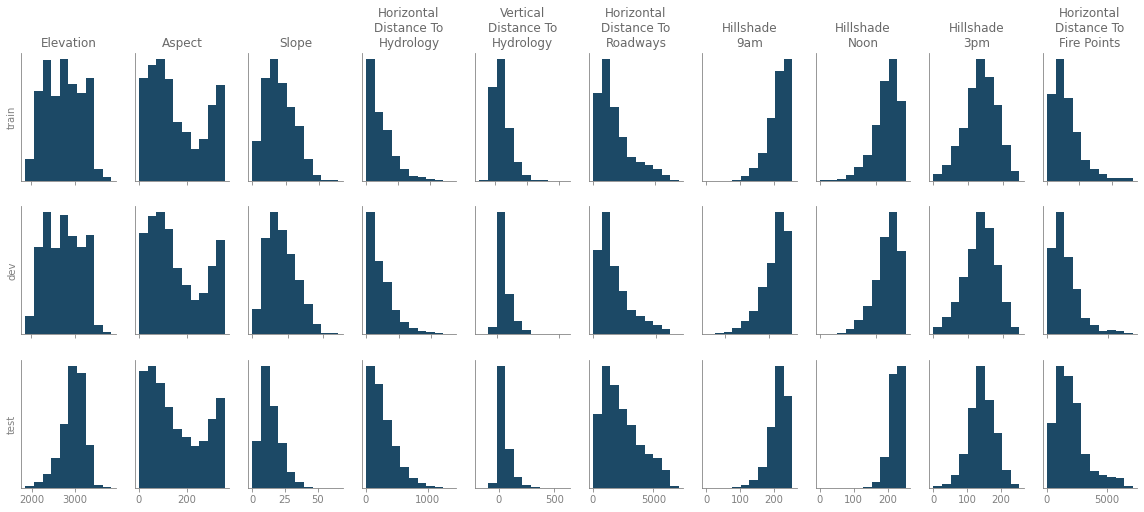

In [ ]:
# Note: When you export this notebook and run it in Jupyter Lab, you need to
# reset the first column of test_kaggle as you did with train and test:
# test_data = test_kaggle.set_index('Id')
# Otherwise, the last row of graphs are one off

# Strip underscores from feature names for nice printing
formatted_cols = copy.deepcopy(train_data.columns).str.replace('_', ' ')

# Plot Formatting
plt.rcParams.update({'text.color' : "dimgrey",
                     'axes.labelcolor' : "grey"})

# For Train, Dev, and Test, plot each non-binary feature
fig, axes = plt.subplots(3, 10)

datasets = [train_data, dev_data, test_kaggle]
data_names = ['train', 'dev', 'test']

# Loop through to show hist of non-binary for each 
for d, data in enumerate(datasets):    # For each dataset
    for i in np.arange(0, 10):          # For each non-binary figure in dataset

        
        
        data.iloc[:, i].plot.hist(ax = axes[d][i], 
                                    figsize = (20,8), 
                                    sharex = True, color = '#1c4966')

        
        # Column and Row names for each plot
        if (i == 0) and (d == 0):    # Top Left Corner
            axes[d][i].set_ylabel(data_names[d])
            axes[d][i].set_title("\n".join(wrap(formatted_cols[i], 12)))
        
        elif i == 0:    # First Column
            axes[d][i].set_ylabel(data_names[d])
    
        elif d == 0:    # First Row
            axes[d][i].set_ylabel('')
            axes[d][i].set_title("\n".join(wrap(formatted_cols[i], 12)))
        else:
            axes[d][i].set_ylabel('')
            
        # For All Plots
        axes[d][i].set_yticks([])
        axes[d][i].spines['top'].set_visible(False)
        axes[d][i].spines['right'].set_visible(False)
        axes[d][i].spines['left'].set_color('grey')
        axes[d][i].spines['bottom'].set_color('grey')
        axes[d][i].tick_params(colors = 'grey')

plt.show()

.... Splits seem to be representative across three sets.


In [ ]:
#train_data.hist(column = ["Elevation", "Aspect", "Slope", "Horizontal_Distance_To_Hydrology",
                          #"Vertical_Distance_To_Hydrology", "Horizontal_Distance_To_Roadways",
                          #"Horizontal_Distance_To_Fire_Points", "Hillshade_9am",
                          #"Hillshade_Noon", "Hillshade_3pm" ],
                          #figsize = (15, 10))

In [ ]:
# # Create figure and axes
# fig, axes = plt.subplots(5, 2)

# ax1 = axes[0][0]
# ax2 = axes[0][1]
# ax3 = axes[1][0]
# ax4 = axes[1][1]
# ax5 = axes[2][0]
# ax6 = axes[2][1]
# ax7 = axes[3][0]
# ax8 = axes[3][1]
# ax9 = axes[4][0]

# # Plot all subplots
# train_data.plot.scatter("Aspect", "Elevation", c="Cover_Type", colormap = "jet", figsize=(15,20), ax=ax1)
# train_data.plot.scatter("Slope", "Elevation", c="Cover_Type", colormap = "jet", figsize=(15,20), ax=ax2)
# train_data.plot.scatter("Horizontal_Distance_To_Hydrology", "Elevation", c="Cover_Type", colormap = "jet", figsize=(15,20), ax=ax3)
# train_data.plot.scatter("Vertical_Distance_To_Hydrology", "Elevation", c="Cover_Type", colormap = "jet", figsize=(15,20), ax=ax4)
# train_data.plot.scatter("Horizontal_Distance_To_Roadways", "Elevation", c="Cover_Type", colormap = "jet", figsize=(15,20), ax=ax5)
# train_data.plot.scatter("Horizontal_Distance_To_Fire_Points", "Elevation", c="Cover_Type", colormap = "jet", figsize=(15,20), ax=ax6)
# train_data.plot.scatter("Hillshade_9am", "Elevation", c="Cover_Type", colormap = "jet", figsize=(15,20), ax=ax7)
# train_data.plot.scatter("Hillshade_Noon", "Elevation", c="Cover_Type", colormap = "jet", figsize=(15,20), ax=ax8)
# train_data.plot.scatter("Hillshade_3pm", "Elevation", c="Cover_Type", colormap = "jet", figsize=(15,20), ax=ax9)

### Scatterplots comparing each feature

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


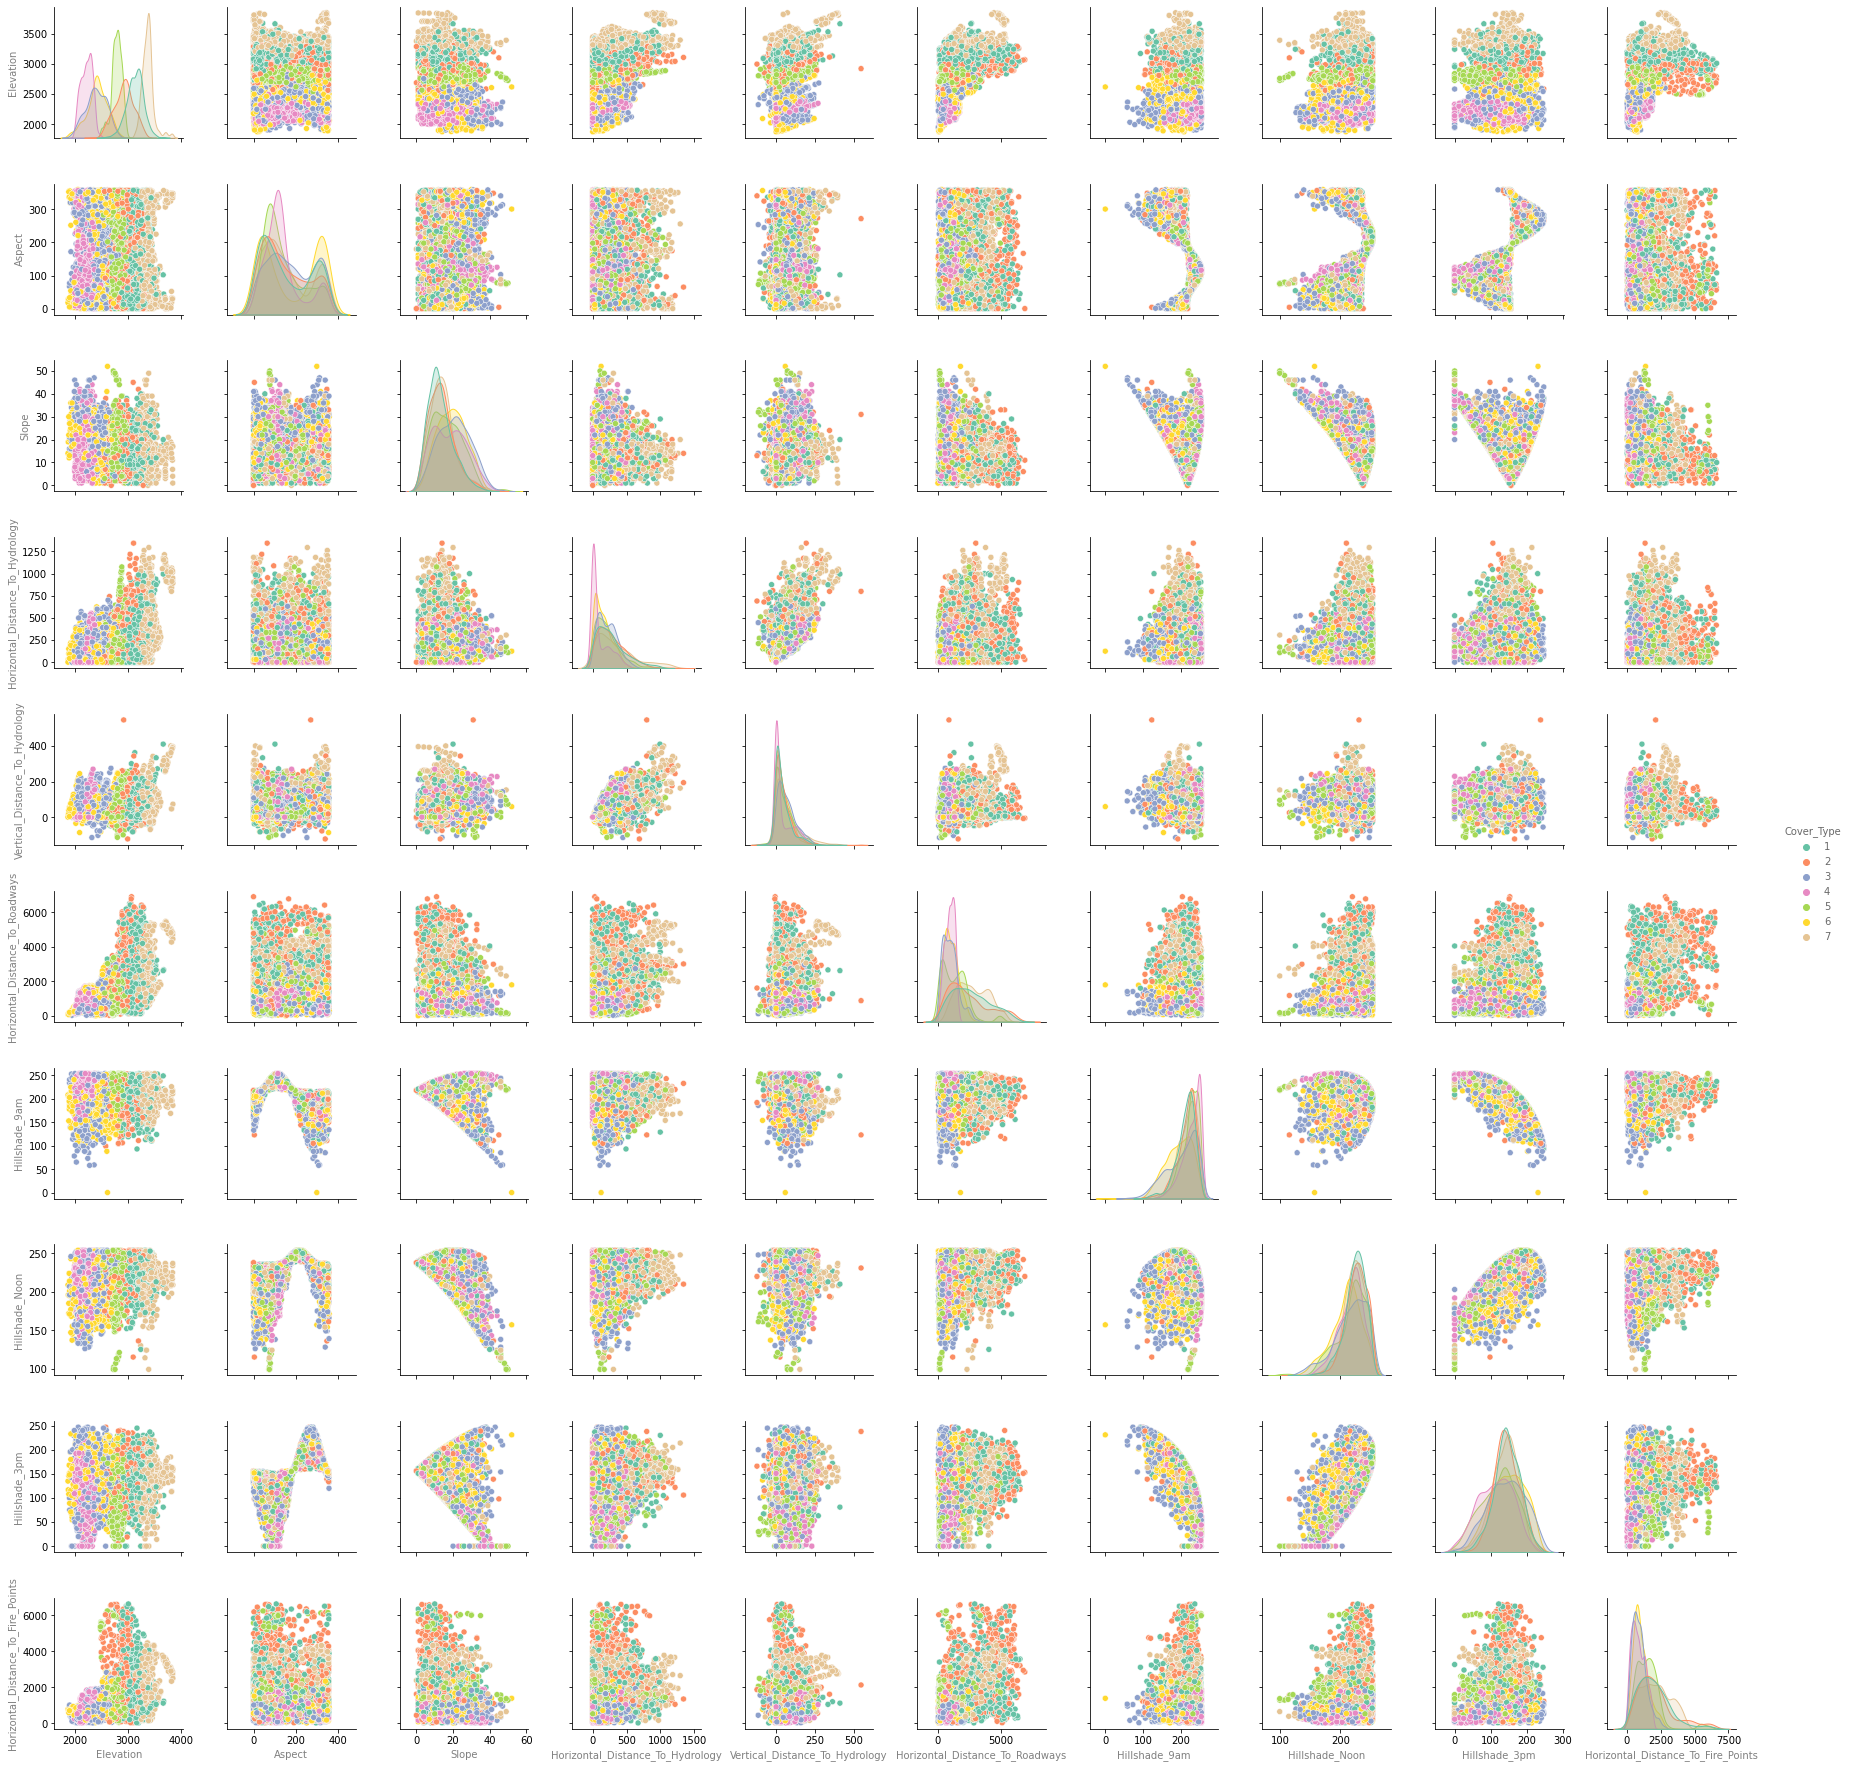

In [ ]:

# Scatterplot Matrix
# ------------------------------------------------------------------------------
# This isn't meant to be a final output (obviously it's too much in its current
# state); just wanted to see all of the distributions at once so we could pick
# out meaningful ones 
# Currently, this takes a long time to run.

train_data_copy = train_data.iloc[:, 0:10]
train_data_copy["Cover_Type"] = train_data.Cover_Type

# The different colors indicate Cover_Type
sns.pairplot(train_data_copy, kind="scatter", hue="Cover_Type", palette="Set2")
plt.show()

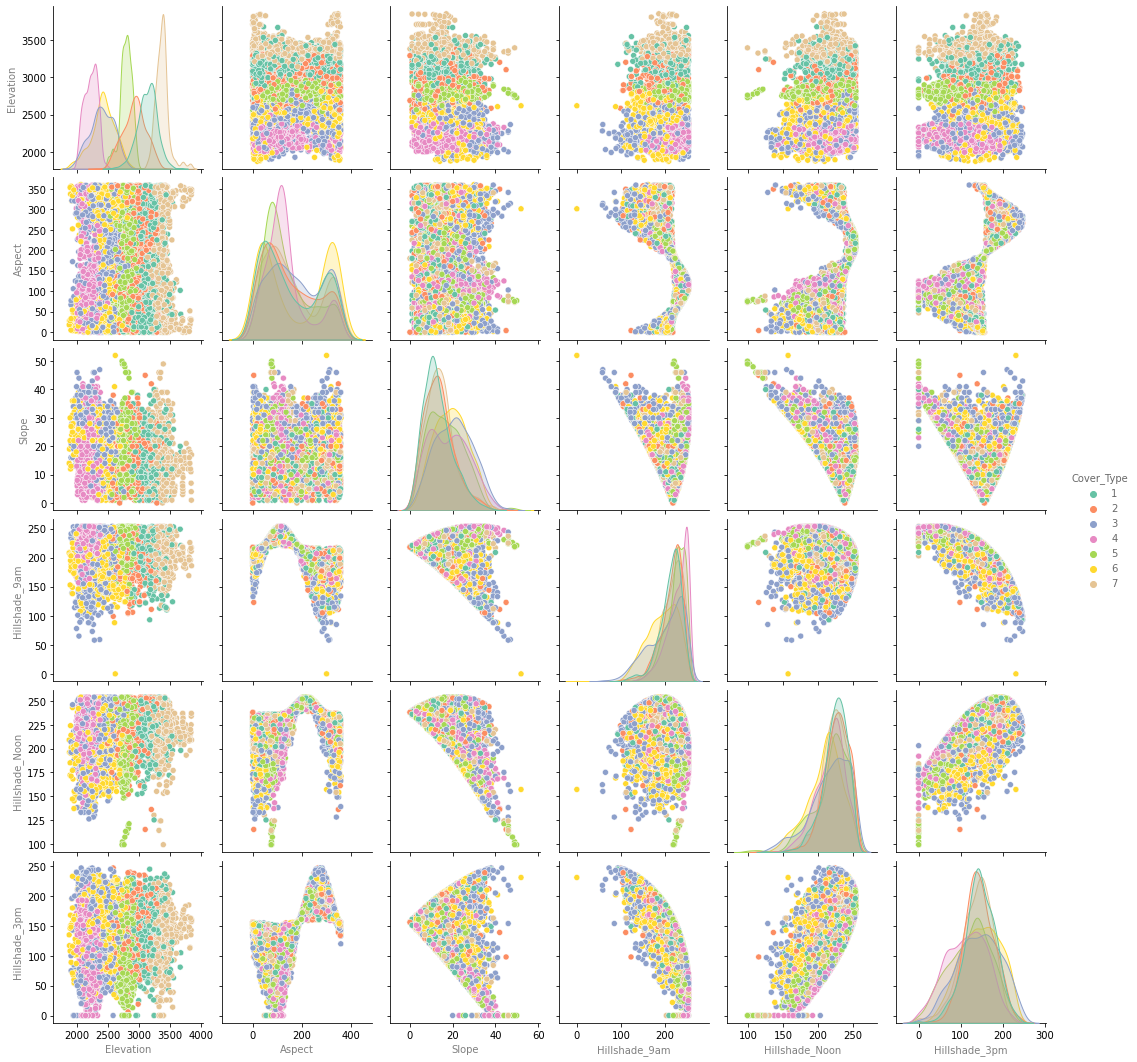

In [ ]:
# Cutting down the number of columns
columns = ["Elevation", "Aspect", "Slope", "Hillshade_9am",
           "Hillshade_Noon", "Hillshade_3pm", "Cover_Type"]

train_data_copy2 = train_data.loc[:, columns]
train_data_copy2

# The different colors indicate Cover_Type
sns.pairplot(train_data_copy2, kind="scatter", hue="Cover_Type", palette="Set2")
plt.show()

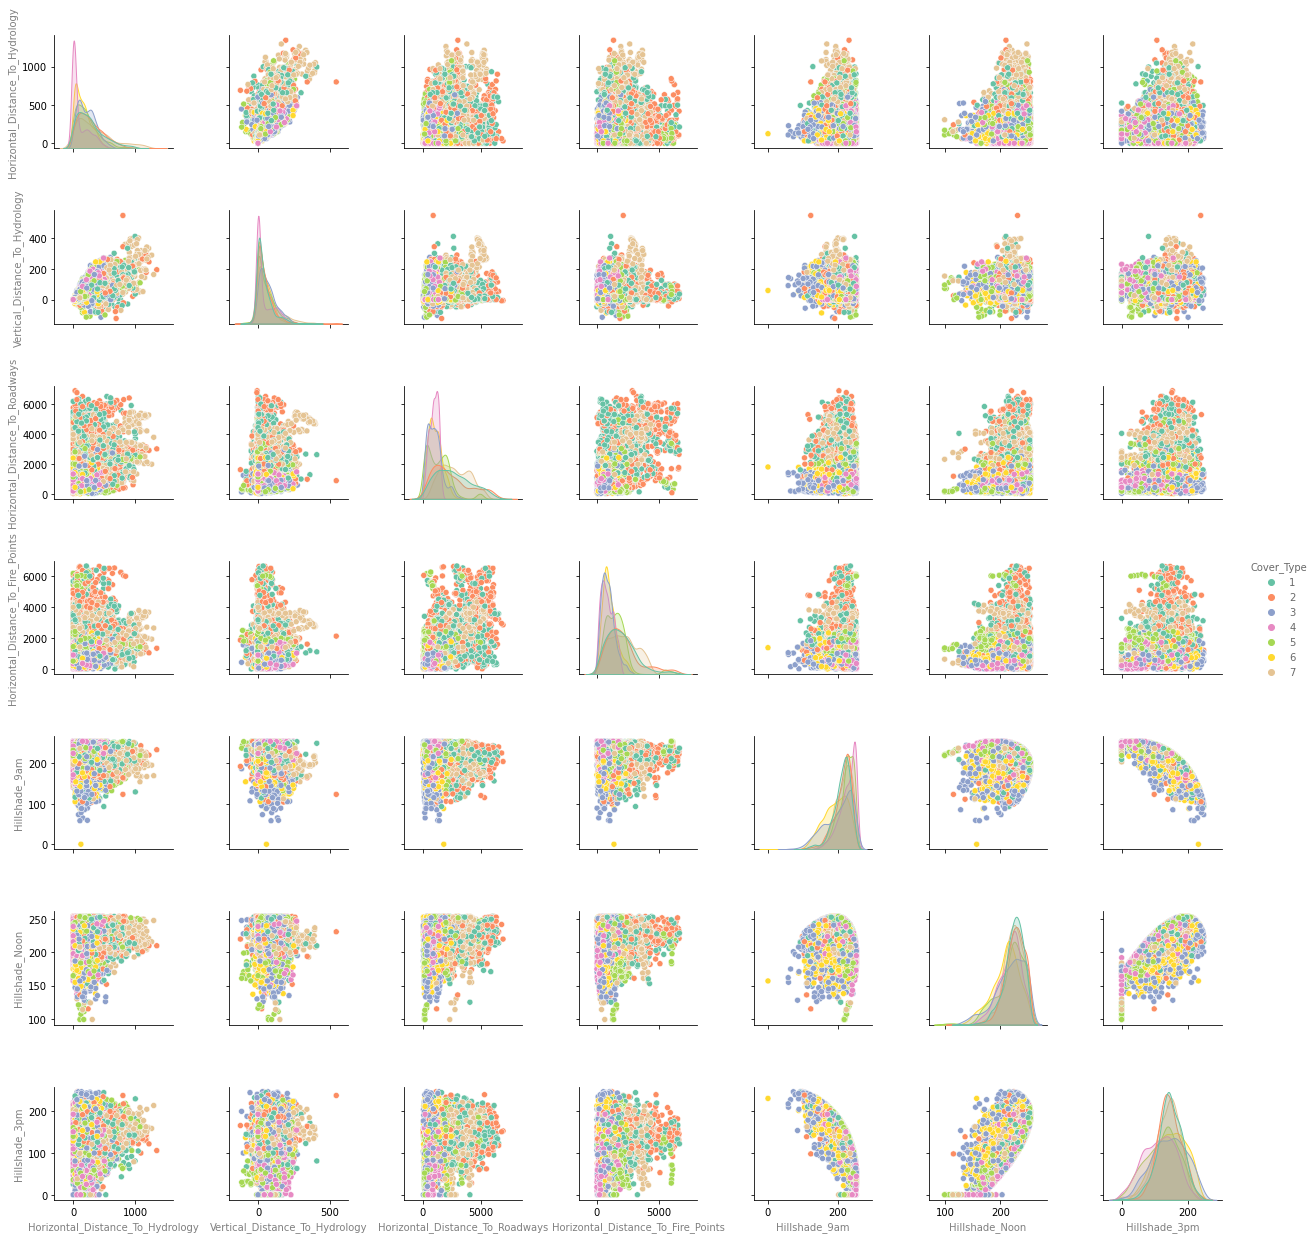

In [ ]:
# Rest of the columns
columns = ["Horizontal_Distance_To_Hydrology",
           "Vertical_Distance_To_Hydrology", "Horizontal_Distance_To_Roadways",
           "Horizontal_Distance_To_Fire_Points", "Hillshade_9am",
           "Hillshade_Noon", "Hillshade_3pm", "Cover_Type"]

train_data_copy3 = train_data.loc[:, columns]
train_data_copy3

# The different colors indicate Cover_Type
sns.pairplot(train_data_copy3, kind="scatter", hue="Cover_Type", palette="Set2")
plt.show()

### Correlation Matrix - Relationships between each non-binary feature
This could aide in identifying any major differences in structure between feature relationships across each dataset. If there are major differences, generalization will suffer

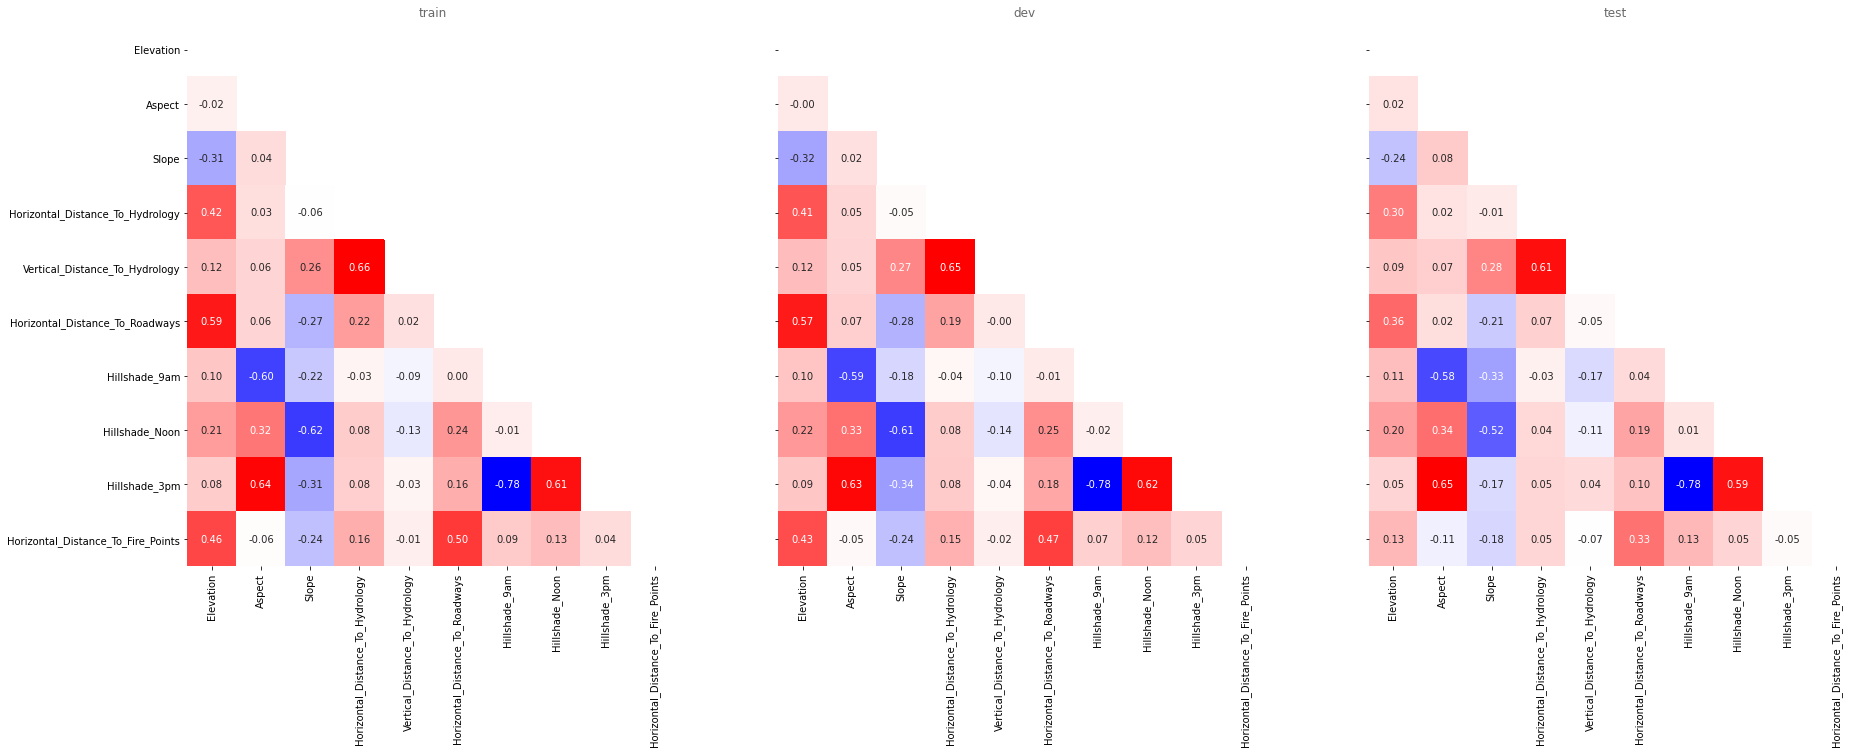

In [ ]:
fig, axes = plt.subplots(1, 3, sharey = True, figsize = (30,10))


# Correlation plot for each dataset - numeric values
for i, data in enumerate(datasets):    # For each dataset

    corr = data.iloc[:, :10].corr()    # Set the correlation matrix
    
    # Mask to upper triangular
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    
    # Plot correlation heatmap
    sns.heatmap(corr, 
                xticklabels = corr.columns.values,
                yticklabels = corr.columns.values, 
                cmap = 'bwr', 
                annot = True, 
                mask = mask, 
                fmt = '.2f',
                ax = axes[i],
                cbar = False).set(title = data_names[i])

plt.show()

### Explore Wilderness Area Binary Counts
Fairly equal representation of wilderness areas, except for Wilderness Area 2

In [ ]:
# 
train_data.groupby(['Wilderness_Area1','Wilderness_Area2','Wilderness_Area3','Wilderness_Area4'])['Cover_Type'].count()

Wilderness_Area1  Wilderness_Area2  Wilderness_Area3  Wilderness_Area4
0                 0                 0                 1                   2312
                                    1                 0                   3206
                  1                 0                 0                    246
1                 0                 0                 0                   1796
Name: Cover_Type, dtype: int64

### Determining if one Soil type exists for each data point

In [ ]:
# Determining if one soil type exists for each data point
soil_type_cols = [col_name for col_name in train_data.columns if 'Soil_Type' in col_name]
try:
  train_data.drop(columns = 'Soil_Type_Count', axis = 1)
except:
  print('Soil_Type_Count not yet created')
train_data['Soil_Type_Count'] = train_data[soil_type_cols].sum(axis = 1)
train_data['Soil_Type_Count'].value_counts()

Soil_Type_Count not yet created


1    7560
Name: Soil_Type_Count, dtype: int64

In [ ]:
try:
  dev_data.drop(columns = 'Soil_Type_Count', axis = 1)
except:
  print('Soil_Type_Count not yet created')
dev_data['Soil_Type_Count'] = dev_data[soil_type_cols].sum(axis = 1)
dev_data['Soil_Type_Count'].value_counts()

Soil_Type_Count not yet created


1    7560
Name: Soil_Type_Count, dtype: int64


Looks like both Soil_Types and Wilderness_Areas are mutually exclusive within the columns (only 1 area/type per row)


### Boxplots for each Feature

Outlier detection

ValueError: ignored

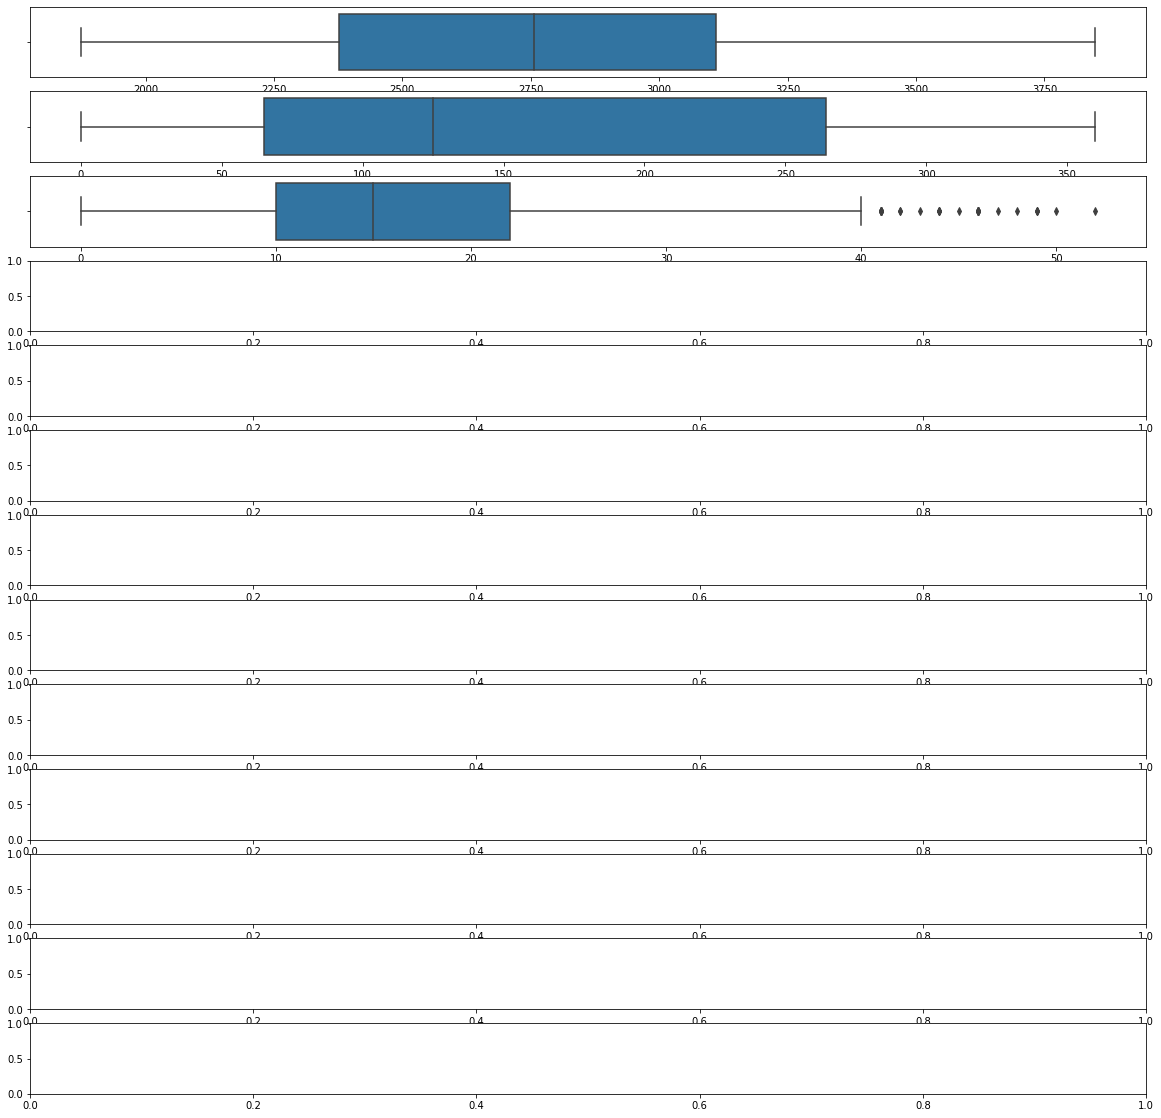

In [ ]:
fig, ax = plt.subplots(13, 1, figsize = (20, 20))

feature_cols = ["Elevation", "Aspect", "Slope", "Total_Distance_To_Hydrology", 
                "Horizontal_Distance_To_Roadways", "Soil_Type", "Wilderness_Area",
                "Horizontal_Distance_To_Fire_Points", "Hillshade_9am",
                "Hillshade_Noon", "Hillshade_3pm", 
                "Vertical_Distance_To_Hydrology", "Horizontal_Distance_To_Hydrology"] # Added these to feature_cols

for i, var in enumerate(feature_cols):
  sns.boxplot(x = var, data = train_data, ax = ax[i])

# sns.boxplot(x = 'variable', y = 'value', data = pd.melt(train_data.iloc[:,:6]), ax = ax[0])
# sns.boxplot(x = 'variable', y = 'value', data = pd.melt(train_data.iloc[:,6:12]), ax = ax[1])
# sns.boxplot(x = 'variable', y = 'value', data = pd.melt(train_data.iloc[:,12:18]), ax = ax[2])
# sns.boxplot(x = 'variable', y = 'value', data = pd.melt(train_data.iloc[:,18:24]), ax = ax[3])
# sns.boxplot(x = 'variable', y = 'value', data = pd.melt(train_data.iloc[:,24:30]), ax = ax[4])
# sns.boxplot(x = 'variable', y = 'value', data = pd.melt(train_data.iloc[:,30:36]), ax = ax[5])
# sns.boxplot(x = 'variable', y = 'value', data = pd.melt(train_data.iloc[:,36:42]), ax = ax[6])
# sns.boxplot(x = 'variable', y = 'value', data = pd.melt(train_data.iloc[:,42:48]), ax = ax[7])
# sns.boxplot(x = 'variable', y = 'value', data = pd.melt(train_data.iloc[:,48:54]), ax = ax[8])
# sns.boxplot(x = 'variable', y = 'value', data = pd.melt(train_data.iloc[:,54:59]), ax = ax[9])
plt.show()

# Data Cleaning/Transformation

Potential operations (may be safe to apply across all models, even if the models don't use all of them):
- Normalize
- Nulls - drop? fillna(0)? 
- "Wilderness_Area" - combining the 4 binary columns into one categorical variable (1-4)
- "Soil_Type" - combining the 40 binary columns into one categorical variable (1-40)
- "Total_Distance_To_Hydrology" - Euclidean distance using "Horizontal" and "Vertical" distances

In [ ]:
# Null values - observation: no null values
# ------------------------------------------------------------------------------
train_data.isnull().sum()
dev_data.isnull().sum()

In [ ]:
# Wilderness Areas and Soil Types
# ------------------------------------------------------------------------------
# Combining wilderness areas into one column, soil types into one column

def get_feature_number(r, col_prefix):
  
  # gets the column name suffix of the true variable (wilderness area/soil type)
  cols = [col_name for col_name in r.index if (col_prefix in col_name) and re.search(r'\d', col_name) is not None]
  feature_subix = r[cols].argmax()
  feature_name = cols[feature_subix]
  feature_num = ''.join([i for i in feature_name if i.isdigit()])
  return int(feature_num)

train_data['Wilderness_Area'] = train_data.apply(lambda x:get_feature_number(x, 'Wilderness_Area'), axis = 1)
train_data['Soil_Type'] = train_data.apply(lambda x:get_feature_number(x, 'Soil_Type'), axis = 1)
dev_data['Wilderness_Area'] = dev_data.apply(lambda x:get_feature_number(x, 'Wilderness_Area'), axis = 1)
dev_data['Soil_Type'] = dev_data.apply(lambda x:get_feature_number(x, 'Soil_Type'), axis = 1)

In [ ]:
train_data['Wilderness_Area'].value_counts()

In [ ]:
train_data['Soil_Type'].value_counts().sort_index().head()

In [ ]:
# Total_Distance_to_Hydrology
# ------------------------------------------------------------------------------
# Create Total_Distance_to_Hydrology based on Euclidean distance
train_data['Total_Distance_To_Hydrology'] = np.sqrt(train_data["Horizontal_Distance_To_Hydrology"]**2 + train_data['Vertical_Distance_To_Hydrology']**2)
dev_data['Total_Distance_To_Hydrology'] = np.sqrt(dev_data["Horizontal_Distance_To_Hydrology"]**2 + dev_data['Vertical_Distance_To_Hydrology']**2)
train_data[["Total_Distance_To_Hydrology", "Horizontal_Distance_To_Hydrology", "Vertical_Distance_To_Hydrology"]].head(10)

In [ ]:
columns = ["Elevation", "Aspect", "Slope", "Horizontal_Distance_To_Hydrology",
           "Vertical_Distance_To_Hydrology", "Horizontal_Distance_To_Roadways",
           "Horizontal_Distance_To_Fire_Points", "Hillshade_9am",
           "Hillshade_Noon", "Hillshade_3pm"]

train_data_copy2 = train_data.loc[:, columns]
train_data_copy2["Cover_Type"] = train_data.Cover_Type
train_data_copy2

# The different colors indicate Cover_Type
sns.pairplot(train_data_copy2, kind="scatter", hue="Cover_Type", palette="Set1")
plt.show()

# Model Building

For the purposes of encapsulation and avoiding conflicts, each model cleaning/building is wrapped in a function. Eventually we will resolve conflicts and combine the tests.


In [ ]:
# KNN Model 1
feature_cols = ["Elevation", "Aspect", "Slope", "Total_Distance_To_Hydrology",
                "Horizontal_Distance_To_Roadways", "Soil_Type", "Wilderness_Area",
                "Horizontal_Distance_To_Fire_Points", "Hillshade_9am",
                "Hillshade_Noon", "Hillshade_3pm"]

X_train = train_data.loc[:, feature_cols]
X_dev = dev_data.loc[:, feature_cols]
Y_train = train_labels.Cover_Type
Y_dev = dev_labels.Cover_Type
#print(type(X_dev))
#print(type(Y_dev))

def knn():
    
    # K nearest neighbors cleaning/training/testing
    k_list = list(range(1, 11))
    for k in k_list:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, Y_train)
        print("Accuracy for k =", k, ":", knn.score(X_dev, Y_dev))

knn()

In [ ]:
def naive_bayes1():
  # naive bayes cleaning/training/testing
  # Gaussian Naive Bayes

  # Features to be used in model
  feature_cols = ["Elevation", "Aspect", "Slope", "Total_Distance_To_Hydrology",
                  "Horizontal_Distance_To_Roadways", "Soil_Type", "Wilderness_Area",
                  "Horizontal_Distance_To_Fire_Points", "Hillshade_9am",
                  "Hillshade_Noon", "Hillshade_3pm"]

  # Create new dataframes with normalized values of data
  nX_train = train_data.loc[:, feature_cols]
  nX_dev = dev_data.loc[:, feature_cols]
  Y_train = train_labels.Cover_Type
  Y_dev = dev_labels.Cover_Type

  # Normalizing features
  for feature in feature_cols:
      nX_train[feature] = nX_train[feature] / np.max(nX_train[feature])
      nX_dev[feature] = nX_dev[feature] / np.max(nX_dev[feature])

  # Generating initial model
  #smoothing_list = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1]
  #for num in smoothing_list:

  model = GaussianNB(var_smoothing=0.001)
  model.fit(nX_train, Y_train)

  # Print the results
  print('Initial Accuracy:', model.score(nX_dev, Y_dev), '\n')

  # Adjusting sigma to test results
  print("Mean sigma:", np.mean(model.sigma_), '\n')

  sigma = 0.3
  model.sigma_ = np.full((7,11), sigma)
  # Print the results
  print('Accuracy for constant sigma =', sigma, ':', model.score(nX_dev, Y_dev), '\n\n')

naive_bayes1()

In [ ]:
def naive_bayes2()
  # Bernoulli Naive Bayes

  # Features to be used in model
  feature_cols = ["Elevation", "Aspect", "Slope", "Total_Distance_To_Hydrology",
                  "Horizontal_Distance_To_Roadways", "Soil_Type", "Wilderness_Area",
                  "Horizontal_Distance_To_Fire_Points", "Hillshade_9am",
                  "Hillshade_Noon", "Hillshade_3pm"]

  # Create new dataframes with normalized values of data
  X_train = train_data.loc[:, feature_cols]
  X_dev = dev_data.loc[:, feature_cols]
  Y_train = train_labels.Cover_Type
  Y_dev = dev_labels.Cover_Type

  # Finding mean of each column and appending to list
  mean_list = []
  for feature in feature_cols:
      mean_list.append(np.mean(nX_train[feature]))

      
  # Taken from Week 3 Tutorial
  # Define a function that applies a threshold to turn real valued forest features into 0/1 features.
  # 0 will mean "short" and 1 will mean "long".
  def binarize_data(data, feature_cols, thresholds=mean_list):
      
      # Initialize a new feature array with the same shape as the original data.
      binarized_data = data

      # Apply a threshold  to each feature.
      i = 0
      for feature in feature_cols:
          binarized_data[feature] = binarized_data[feature] > thresholds[i]
          i+=1
      return binarized_data

  # Create new binarized training and test data
  binarized_train_data = binarize_data(X_train, feature_cols)
  binarized_dev_data = binarize_data(X_dev, feature_cols)

  # Model using default binarization
  model = BernoulliNB()
  model.fit(X_train, Y_train)

  # Print the results
  print('Initial Accuracy using Bernoulli NB:', model.score(X_dev, Y_dev), '\n')

  # Model using adjusted binarization
  model2 = BernoulliNB()
  model2.fit(binarized_train_data, Y_train)

  # Print the results
  print('Accuracy after adjusted binarization:', model2.score(binarized_dev_data, Y_dev), '\n\n')
naive_bayes2()

In [ ]:
def logistic_regression():
  # log regression cleaning/training/testing

  clf = LogisticRegression(C=100)

  feature_cols = ["Elevation", "Aspect", "Slope", "Total_Distance_To_Hydrology",
                          "Horizontal_Distance_To_Roadways", "Soil_Type", "Wilderness_Area",
                          "Horizontal_Distance_To_Fire_Points", "Hillshade_9am",
                          "Hillshade_Noon", "Hillshade_3pm"]
  
  X_train = train_data.loc[:, feature_cols]
  X_dev = dev_data.loc[:, feature_cols]
  y_train = train_labels.Cover_Type
  y_dev = dev_labels.Cover_Type

  clf.fit(X_train, y_train)
  pred_y_train = clf.predict(X_train)
  pred_y_dev = clf.predict(X_dev)
  f1_score_train = metrics.f1_score(pred_y_train, y_train, average = 'weighted')
  f1_score_dev = metrics.f1_score(pred_y_dev, y_dev, average = 'weighted')
  print(f1_score_train, f1_score_dev)

logistic_regression()

In [ ]:
# Removing labels and new column from dataset - Not permanent
train_data2 = copy.deepcopy(train_data).drop(columns = ['Cover_Type', 'Soil_Type_Count'])
dev_data2 = copy.deepcopy(dev_data).drop(columns = ['Cover_Type'])

# Define DT funciton
def decision_trees():
  # decision tree cleaning/training/testing
  
  dt = DecisionTreeClassifier(criterion = 'entropy', max_leaf_nodes = 50)
  dt.fit(train_data2, train_labels)
  
  print('Accuracy:', dt.score(dev_data2, dev_labels))
  
  # Print Decision Tree
  export_graphviz(dt, out_file = 'dot_data.dot')

  call(['dot', '-Tpng', 'dot_data.dot', '-o', 'dot_data.png', '-Gdpi=600'])

  display(Image(filename='dot_data.png'))

decision_trees()

In [ ]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import time

np.random.seed(0)

# convert dataframe to numpy array
X = np.array(train_kaggle.set_index('Id'))
Y = np.array(train_kaggle[['Id', 'Cover_Type']].set_index('Id'))

# random sampling of data
# note that each time this cell is run, the data is reshuffled resulting in different order
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]

X_train, X_dev, y_train, y_dev = train_test_split(X, Y, test_size = 0.2)

# scale data to range [0, 1]
train_data_minmax = MinMaxScaler().fit_transform(X_train[:, :10])
dev_data_minmax = MinMaxScaler().fit_transform(X_dev[:, :10])

In [ ]:
# GridSearchCV best parameters
# This will take 5 minutes to run
# Not necessary to run

def best_svc(params):
    gscv = GridSearchCV(SVC(), param_grid=params, scoring='accuracy')
    gscv.fit(train_data_minmax, y_train.ravel())
    
    df = pd.DataFrame(gscv.cv_results_)
    print(df.loc[:,['params', 'mean_test_score', 'rank_test_score']])
    
    return gscv

params = {'C': [1, 10, 100, 1000],
          'gamma': [1, 0.5, 0.1, 0.01],
          'kernel': ['rbf']}

best_svm = best_svc(params)

print(f'\nBest SVC parameters: {best_svm.best_params_}')

In [ ]:
def svm():
  # SVM cleaning/training/testing

  svm = SVC(
      C=1000
      ,gamma=1
      ,kernel='rbf'
          )

  svm.fit(train_data_minmax, y_train.ravel())
  dev_prediction = svm.predict(dev_data_minmax)

  print(f'Best f1-score for SVC: {metrics.accuracy_score(y_dev, dev_prediction):.4f}\n')
  print(classification_report(y_dev, dev_prediction))  

svm()

In [ ]:
# Comparison of different algos' f1 scores